In [1]:
!conda install -c conda-forge folium=0.5.0 --yes
!pip install geocoder
!wget -O Geospatial.csv http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv
!pip install xlrd
!pip install  psycopg2-binary
!pip install geopandas
!pip install pyspark
!pip install descartes
!pip install pyepsg
!pip install shapely
!pip install census
!pip install us

from geopandas.tools import sjoin
from shapely.geometry import Point # Point class
from shapely.geometry import shape # shape() is a function to convert geo objects through the interface
from zipfile import ZipFile
import io
import zipfile
import shapefile
import pyepsg
import requests
from bs4 import BeautifulSoup
from pandas import DataFrame as df
import pandas as pd
import numpy as np 
import folium
#p sure I don't need the below import statement, but we'll see
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopandas as gpd
import fiona
import pprint
from pyspark import SparkContext
from concurrent.futures import ThreadPoolExecutor

sc =SparkContext()

%matplotlib inline

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    altair-4.0.0               |             py_0         606 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be 

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
my_file = project.get_file("Mcdonalds_USA_CAN.csv")
my_file.seek(0)
df = pd.read_csv(my_file, encoding = "ISO-8859-1")
#df

In [6]:
Mcdf = df[df['Name'].str.contains(",NY")]

In [7]:
Mcdf.reset_index(drop=True, inplace = True)

Mcdf.columns = ['GPSY', 'GPSX', 'Name', 'Address|Services']

#Mcdf

In [8]:
m = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
for i in range(0,len(Mcdf)):
    folium.Marker([Mcdf.iloc[i]['GPSX'], Mcdf.iloc[i]['GPSY']], popup=Mcdf.iloc[i]['Name']).add_to(m)
m

In [9]:
url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
request = requests.get(url)
b = bytes(request.content)
with fiona.BytesCollection(b) as f:
    crs = f.crs
    gdf = gpd.GeoDataFrame.from_features(f, crs=crs)
    
gdf = gdf.explode()
print(gdf)
gdf.reset_index(drop=True, inplace = True)
print(gdf)

      boro_code      boro_name    shape_area     shape_leng  \
0 0         2.0          Bronx  1.186612e+09  462958.187332   
  1         2.0          Bronx  1.186612e+09  462958.187332   
  2         2.0          Bronx  1.186612e+09  462958.187332   
  3         2.0          Bronx  1.186612e+09  462958.187332   
  4         2.0          Bronx  1.186612e+09  462958.187332   
  5         2.0          Bronx  1.186612e+09  462958.187332   
  6         2.0          Bronx  1.186612e+09  462958.187332   
  7         2.0          Bronx  1.186612e+09  462958.187332   
  8         2.0          Bronx  1.186612e+09  462958.187332   
  9         2.0          Bronx  1.186612e+09  462958.187332   
  10        2.0          Bronx  1.186612e+09  462958.187332   
  11        2.0          Bronx  1.186612e+09  462958.187332   
  12        2.0          Bronx  1.186612e+09  462958.187332   
  13        2.0          Bronx  1.186612e+09  462958.187332   
  14        2.0          Bronx  1.186612e+09  462958.18

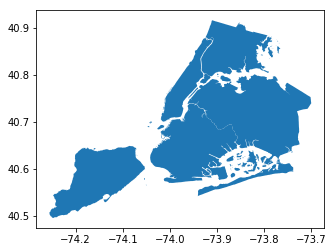

In [10]:
gdf.plot()
#print(Mcdf)

In [11]:
#print(Mcdf)
point = Point(Mcdf.loc[3]['GPSY'],Mcdf.loc[3]['GPSX'])

for i in range(0,len(gdf)):
    if gdf.iloc[i]['geometry'].contains(point):
        print("yes!")
        
#gdf.iloc[0]['geometry'].contains(point)

In [12]:
%%time
#newdf = pd.DataFrame()
for i in range(0,len(Mcdf)):
    point  = Point(Mcdf.loc[i,'GPSY'],Mcdf.loc[i,'GPSX'])
    checker = False
    
    for j in range(0,len(gdf)):
        if gdf.iloc[j]['geometry'].contains(point):
            checker = True
    
    if not checker:
        Mcdf.drop(i, inplace=True)
Mcdf.reset_index(drop=True, inplace = True)
print(Mcdf)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


          GPSY       GPSX                                   Name  \
0   -73.912190  40.775120         McDonalds PlacePlay-Astoria,NY   
1   -73.919000  40.758980                   McDonalds-Astoria,NY   
2   -73.779666  40.757872                   McDonalds-Bayside,NY   
3   -73.914850  40.844490                     McDonalds-Bronx,NY   
4   -73.915800  40.839580                     McDonalds-Bronx,NY   
5   -73.877180  40.840110                     McDonalds-Bronx,NY   
6   -73.852230  40.872720                     McDonalds-Bronx,NY   
7   -73.846670  40.844680                     McDonalds-Bronx,NY   
8   -73.878100  40.828580                     McDonalds-Bronx,NY   
9   -73.890650  40.835790                     McDonalds-Bronx,NY   
10  -73.874470  40.823830           McDonalds PlayPlace-Bronx,NY   
11  -73.904200  40.842090                     McDonalds-Bronx,NY   
12  -73.917210  40.849570           McDonalds PlayPlace-Bronx,NY   
13  -73.844811  40.849610                     Mc

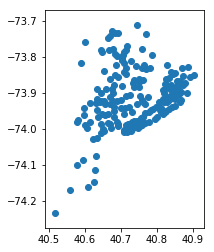

In [13]:
gdf2 = gpd.GeoDataFrame(Mcdf, geometry=gpd.points_from_xy(Mcdf.GPSX, Mcdf.GPSY))
gdf2.plot()

In [14]:
m = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
for i in range(0,len(Mcdf)):
    folium.Marker([Mcdf.iloc[i]['GPSX'], Mcdf.iloc[i]['GPSY']], popup=Mcdf.iloc[i]['Name']).add_to(m)
m

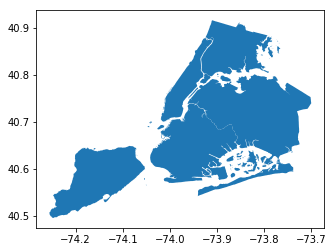

In [15]:
gdf.plot()

In [16]:
#https://data.cityofnewyork.us/api/geospatial/v2h8-6mxf?method=export&format=Shapefile
url = 'https://data.cityofnewyork.us/api/geospatial/v2h8-6mxf?method=export&format=Shapefile'
request = requests.get(url)
b = bytes(request.content)
with fiona.BytesCollection(b) as f:
    crs = f.crs
    blocks = gpd.GeoDataFrame.from_features(f, crs=crs)
blocks

,bctcb2010,boro_code,boro_name,cb2010,ct2010,geometry,shape_area,shape_leng
0,50009001000,5,Staten Island,1000,000900,"POLYGON ((-74.07921 40.64343, -74.07914 40.643...",2.445896e+05,2508.948115
1,50020011000,5,Staten Island,1000,002001,"POLYGON ((-74.07062 40.61086, -74.07164 40.610...",1.110063e+05,1345.886422
2,50027001000,5,Staten Island,1000,002700,"POLYGON ((-74.07524 40.62601, -74.07750 40.625...",1.504068e+05,1703.381172
3,50040001000,5,Staten Island,1000,004000,"POLYGON ((-74.08709 40.61117, -74.08795 40.610...",1.412966e+05,1511.173743
4,50064001000,5,Staten Island,1000,006400,"POLYGON ((-74.07644 40.60100, -74.07670 40.600...",2.007850e+05,1978.243852
5,50074001000,5,Staten Island,1000,007400,"POLYGON ((-74.06589 40.59683, -74.06633 40.596...",1.390840e+05,1540.875503
6,50075001000,5,Staten Island,1000,007500,"POLYGON ((-74.08569 40.63661, -74.08513 40.636...",1.235605e+05,1412.642887
7,50077001000,5,Staten Island,1000,007700,"POLYGON ((-74.08709 40.64033, -74.08721 40.639...",2.057710e+05,2421.037307
8,50112011000,5,Staten Island,1000,011201,"POLYGON ((-74.08654 40.58373, -74.08659 40.583...",1.961123e+05,1943.029020
9,50112021000,5,Staten Island,1000,011202,"POLYGON ((-74.09940 40.57919, -74.09980 40.578...",9.273776e+04,1233.682178


In [17]:
url = 'https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_36_tract10.zip'
request = requests.get(url)
b = bytes(request.content)
with fiona.BytesCollection(b) as f:
    crs = f.crs
    Tracts2010 = gpd.GeoDataFrame.from_features(f, crs=crs)
Tracts2010

,ALAND10,AWATER10,COUNTYFP10,FUNCSTAT10,GEOID10,INTPTLAT10,INTPTLON10,MTFCC10,NAME10,NAMELSAD10,STATEFP10,TRACTCE10,geometry
0,81287303,16045715,099,S,36099951000,+42.5844045,-076.6966089,G5020,9510,Census Tract 9510,36,951000,"POLYGON ((-76.72291 42.54608, -76.72417 42.546..."
1,142019951,34216025,099,S,36099950700,+42.8428740,-076.8585501,G5020,9507,Census Tract 9507,36,950700,"POLYGON ((-76.80962 42.81351, -76.81023 42.808..."
2,23348189,45010,099,S,36099950500,+42.9303542,-076.8789131,G5020,9505,Census Tract 9505,36,950500,"POLYGON ((-76.86224 42.90883, -76.86236 42.910..."
3,147014747,8301583,099,S,36099950100,+42.9849056,-076.8452011,G5020,9501,Census Tract 9501,36,950100,"POLYGON ((-76.76980 42.94902, -76.77013 42.949..."
4,168477163,34879017,099,S,36099950900,+42.6232947,-076.8139114,G5020,9509,Census Tract 9509,36,950900,"POLYGON ((-76.86347 42.67961, -76.86342 42.679..."
5,180751254,70618921,099,S,36099950800,+42.7480815,-076.8373025,G5020,9508,Census Tract 9508,36,950800,"POLYGON ((-76.80962 42.81351, -76.80953 42.814..."
6,16094149,334900,099,S,36099950200,+42.9324483,-076.7869155,G5020,9502,Census Tract 9502,36,950200,"POLYGON ((-76.74562 42.94189, -76.74622 42.941..."
7,96109901,3325146,063,S,36063024102,+43.3357362,-078.5481059,G5020,241.02,Census Tract 241.02,36,024102,"POLYGON ((-78.57646 43.30494, -78.58075 43.305..."
8,125851156,4835104,063,S,36063024302,+43.2726719,-078.8129431,G5020,243.02,Census Tract 243.02,36,024302,"POLYGON ((-78.83016 43.30625, -78.83015 43.306..."
9,723795,0,063,S,36063020900,+43.0981122,-079.0450967,G5020,209,Census Tract 209,36,020900,"POLYGON ((-79.04139 43.09507, -79.04150 43.095..."


In [18]:
%%time
for i in range(0,len(Tracts2010)):
    tractInQuestion = Tracts2010.loc[i]['geometry']
    checker = False
    
    for j in range(0,len(gdf)):
        if gdf.iloc[j]['geometry'].contains(tractInQuestion):

            checker = True
            break
    
    if not checker:
        Tracts2010.drop(i, inplace=True)
Tracts2010.reset_index(drop=True, inplace = True)
print(Tracts2010)

      ALAND10  AWATER10 COUNTYFP10 FUNCSTAT10      GEOID10   INTPTLAT10  \
0      303568         0        085          S  36085001700  +40.6343907   
1      799131         0        085          S  36085000800  +40.6119576   
2      231877         0        085          S  36085000900  +40.6422065   
3      491478         0        085          S  36085002001  +40.6070041   
4      795543         0        085          S  36085002002  +40.6015417   
5     1045192         0        085          S  36085013204  +40.5594209   
6      250358         0        085          S  36085002700  +40.6235871   
7      526903         0        085          S  36085002900  +40.6196581   
8      325090         0        085          S  36085001100  +40.6387763   
9      854273         0        085          S  36085003300  +40.6256016   
10     410502         0        085          S  36085003600  +40.6110561   
11     582557       506        085          S  36085003900  +40.6213704   
12    1185968         0  

In [19]:
Tracts2010.drop(['ALAND10', 'AWATER10', 'COUNTYFP10', 'FUNCSTAT10', 'MTFCC10', 'NAME10', 'NAMELSAD10', 'INTPTLAT10', 'INTPTLON10', 
                'STATEFP10','TRACTCE10'], axis=1, inplace=True)
Tracts2010["HasMcdonaldsFlag"] = 0
print(Tracts2010)


          GEOID10                                           geometry  \
0     36085001700  POLYGON ((-74.08508 40.63469, -74.08444 40.635...   
1     36085000800  POLYGON ((-74.07246 40.61408, -74.07278 40.614...   
2     36085000900  POLYGON ((-74.08218 40.64437, -74.08237 40.644...   
3     36085002001  POLYGON ((-74.07659 40.60600, -74.07780 40.606...   
4     36085002002  POLYGON ((-74.06082 40.59990, -74.06099 40.599...   
5     36085013204  POLYGON ((-74.13377 40.55281, -74.13444 40.553...   
6     36085002700  POLYGON ((-74.07785 40.62120, -74.07804 40.621...   
7     36085002900  POLYGON ((-74.08580 40.62036, -74.08570 40.620...   
8     36085001100  POLYGON ((-74.07813 40.63817, -74.07879 40.638...   
9     36085003300  POLYGON ((-74.08575 40.63396, -74.08534 40.633...   
10    36085003600  POLYGON ((-74.07497 40.60951, -74.07533 40.609...   
11    36085003900  POLYGON ((-74.08872 40.62590, -74.08853 40.624...   
12    36085004000  POLYGON ((-74.08323 40.61622, -74.08274 40.61

In [20]:
for i in range(0,len(Mcdf)):
    point  = Point(Mcdf.loc[i,'GPSY'],Mcdf.loc[i,'GPSX'])
    
    for j in range(0,len(Tracts2010)):
        if Tracts2010.loc[j,'geometry'].contains(point):
#            print("did IT!")
            Tracts2010.loc[j,'HasMcdonaldsFlag'] = 1
#            print(Tracts2010.iloc[j])

print(Tracts2010)

          GEOID10                                           geometry  \
0     36085001700  POLYGON ((-74.08508 40.63469, -74.08444 40.635...   
1     36085000800  POLYGON ((-74.07246 40.61408, -74.07278 40.614...   
2     36085000900  POLYGON ((-74.08218 40.64437, -74.08237 40.644...   
3     36085002001  POLYGON ((-74.07659 40.60600, -74.07780 40.606...   
4     36085002002  POLYGON ((-74.06082 40.59990, -74.06099 40.599...   
5     36085013204  POLYGON ((-74.13377 40.55281, -74.13444 40.553...   
6     36085002700  POLYGON ((-74.07785 40.62120, -74.07804 40.621...   
7     36085002900  POLYGON ((-74.08580 40.62036, -74.08570 40.620...   
8     36085001100  POLYGON ((-74.07813 40.63817, -74.07879 40.638...   
9     36085003300  POLYGON ((-74.08575 40.63396, -74.08534 40.633...   
10    36085003600  POLYGON ((-74.07497 40.60951, -74.07533 40.609...   
11    36085003900  POLYGON ((-74.08872 40.62590, -74.08853 40.624...   
12    36085004000  POLYGON ((-74.08323 40.61622, -74.08274 40.61

In [21]:
Tracts2010["PopDensity"] = None
Tracts2010["%White"] = None
Tracts2010["%AfricanAmerican"] = None
Tracts2010["%AmericanIndianOrAlaskan"] = None
Tracts2010["%Asian"] = None
Tracts2010["%NativeHawaiianOrPacificIslander"] = None
Tracts2010["%SomeOtherRace"] = None
Tracts2010["%2RacesOrMore"] = None
Tracts2010["MedianIncome"] = None
Tracts2010["%BelowPovertyLine"] = None
Tracts2010["%SocialSecurityIncome"] = None
Tracts2010["%Male0-5"] = None
Tracts2010["%Male5-9"] = None
Tracts2010["%Male10-14"] = None
Tracts2010["%Male15-17"] = None
Tracts2010["%Male18-19"] = None
Tracts2010["%Male20"] = None
Tracts2010["%Male21"] = None
Tracts2010["%Male22-24"] = None
Tracts2010["%Male25-29"] = None
Tracts2010["%Male30-34"] = None
Tracts2010["%Male35-39"] = None
Tracts2010["%Male40-44"] = None
Tracts2010["%Male45-49"] = None
Tracts2010["%Male50-54"] = None
Tracts2010["%Male55-59"] = None
Tracts2010["%Male60-64"] = None
Tracts2010["%Male65-69"] = None
Tracts2010["%Male70-74"] = None
Tracts2010["%Male75-79"] = None
Tracts2010["%Male80-84"] = None
Tracts2010["%Male85+"] = None
Tracts2010["%Female0-5"] = None
Tracts2010["%Female5-9"] = None
Tracts2010["%Female10-14"] = None
Tracts2010["%Female15-17"] = None
Tracts2010["%Female18-19"] = None
Tracts2010["%Female20"] = None
Tracts2010["%Female21"] = None
Tracts2010["%Female22-24"] = None
Tracts2010["%Female25-29"] = None
Tracts2010["%Female30-34"] = None
Tracts2010["%Female35-39"] = None
Tracts2010["%Female40-44"] = None
Tracts2010["%Female45-49"] = None
Tracts2010["%Female50-54"] = None
Tracts2010["%Female55-59"] = None
Tracts2010["%Female60-64"] = None
Tracts2010["%Female65-69"] = None
Tracts2010["%Female70-74"] = None
Tracts2010["%Female75-79"] = None
Tracts2010["%Female80-84"] = None
Tracts2010["%Female85+"] = None

#Tracts2010

In [22]:
class CensusVariable:
    def __init__(self, census_var, description):
        self.census_var = census_var
        self.description = description

DESIRED_VARIABLES = [
    CensusVariable("NAME", "Tract Name"),
    CensusVariable("B02001_001E", "Estimate!!Total"),
    CensusVariable("B02001_002E", "Estimate!!Total!!White alone"),
    CensusVariable("B02001_003E", "Estimate!!Total!!Black or African American alone"),
    CensusVariable("B02001_004E", "Estimate!!Total!!American Indian and Alaska Native alone"),
    CensusVariable("B02001_005E", "Estimate!!Total!!Asian alone"),
    CensusVariable("B02001_006E", "Estimate!!Total!!Native Hawaiian and Other Pacific Islander alone"),
    CensusVariable("B02001_007E", "Estimate!!Total!!Some other race alone"),
    CensusVariable("B02001_008E", "Estimate!!Total!!Two or more races"),
    CensusVariable("B02001_009E", "Estimate!!Total!!Two or more races!!Two races including Some other race"),
    CensusVariable("B02001_010E", "Estimate!!Total!!Two or more races!!Two races excluding Some other race, and three or more races"),
    CensusVariable("B06011_001E", "Estimate!!Median income in the past 12 months!!Total"),
    CensusVariable("B17001_002E", "Estimate!!Total!!Income in the past 12 months below poverty level"),
    CensusVariable("B19055_002E", "Estimate!!Total!!With Social Security income"),
    CensusVariable("B01001_002E", "Estimate!!Total!!Male"),
    CensusVariable("B01001_003E", "Estimate!!Total!!Male!!Under 5 years"),
    CensusVariable("B01001_004E", "Estimate!!Total!!Male!!5 to 9 years"),
    CensusVariable("B01001_005E", "Estimate!!Total!!Male!!10 to 14 years"),
    CensusVariable("B01001_006E", "Estimate!!Total!!Male!!15 to 17 years"),
    CensusVariable("B01001_007E", "Estimate!!Total!!Male!!18 and 19 years"),
    CensusVariable("B01001_008E", "Estimate!!Total!!Male!!20 years"),
    CensusVariable("B01001_009E", "Estimate!!Total!!Male!!21 years"),
    CensusVariable("B01001_010E", "Estimate!!Total!!Male!!22 to 24 years"),
    CensusVariable("B01001_011E", "Estimate!!Total!!Male!!25 to 29 years"),
    CensusVariable("B01001_012E", "Estimate!!Total!!Male!!30 to 34 years"),
    CensusVariable("B01001_013E", "Estimate!!Total!!Male!!35 to 39 years"),
    CensusVariable("B01001_014E", "Estimate!!Total!!Male!!40 to 44 years"),
    CensusVariable("B01001_015E", "Estimate!!Total!!Male!!45 to 49 years"),
    CensusVariable("B01001_016E", "Estimate!!Total!!Male!!50 to 54 years"),
    CensusVariable("B01001_017E", "Estimate!!Total!!Male!!55 to 59 years"),
    CensusVariable("B01001_018E", "Estimate!!Total!!Male!!60 and 61 years"),
    CensusVariable("B01001_019E", "Estimate!!Total!!Male!!62 to 64 years"),
    CensusVariable("B01001_020E", "Estimate!!Total!!Male!!65 and 66 years"),
    CensusVariable("B01001_021E", "Estimate!!Total!!Male!!67 to 69 years"),
    CensusVariable("B01001_022E", "Estimate!!Total!!Male!!70 to 74 years"),
    CensusVariable("B01001_023E", "Estimate!!Total!!Male!!75 to 79 years"),
    CensusVariable("B01001_024E", "Estimate!!Total!!Male!!80 to 84 years"),
    CensusVariable("B01001_025E", "Estimate!!Total!!Male!!85 years and over"),
    CensusVariable("B01001_026E", "Estimate!!Total!!Female"),
    CensusVariable("B01001_027E", "Estimate!!Total!!Female!!Under 5 years"),
    CensusVariable("B01001_028E", "Estimate!!Total!!Female!!5 to 9 years"),
    CensusVariable("B01001_029E", "Estimate!!Total!!Female!!10 to 14 years"),
    CensusVariable("B01001_030E", "Estimate!!Total!!Female!!15 to 17 years"),
    CensusVariable("B01001_031E", "Estimate!!Total!!Female!!18 and 19 years"),
    CensusVariable("B01001_032E", "Estimate!!Total!!Female!!20 years"),
    CensusVariable("B01001_033E", "Estimate!!Total!!Female!!21 years"),
    CensusVariable("B01001_034E", "Estimate!!Total!!Female!!22 to 24 years"),
    CensusVariable("B01001_035E", "Estimate!!Total!!Female!!25 to 29 years"),
    CensusVariable("B01001_036E", "Estimate!!Total!!Female!!30 to 34 years"),
    CensusVariable("B01001_037E", "Estimate!!Total!!Female!!35 to 39 years"),
    CensusVariable("B01001_038E", "Estimate!!Total!!Female!!40 to 44 years"),
    CensusVariable("B01001_039E", "Estimate!!Total!!Female!!45 to 49 years"),
    CensusVariable("B01001_040E", "Estimate!!Total!!Female!!50 to 54 years"),
    CensusVariable("B01001_041E", "Estimate!!Total!!Female!!55 to 59 years"),
    CensusVariable("B01001_042E", "Estimate!!Total!!Female!!60 and 61 years"),
    CensusVariable("B01001_043E", "Estimate!!Total!!Female!!62 to 64 years"),
    CensusVariable("B01001_044E", "Estimate!!Total!!Female!!65 and 66 years"),
    CensusVariable("B01001_045E", "Estimate!!Total!!Female!!67 to 69 years"),
    CensusVariable("B01001_046E", "Estimate!!Total!!Female!!70 to 74 years"),
    CensusVariable("B01001_047E", "Estimate!!Total!!Female!!75 to 79 years"),
    CensusVariable("B01001_048E", "Estimate!!Total!!Female!!80 to 84 years"),
    CensusVariable("B01001_049E", "Estimate!!Total!!Female!!85 years and over")
]
 
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
 
def get_stats_for_geo_id(geo_id):
    global DESIRED_VARIABLES
   
    if(len(geo_id) != 11):
        return "Invalid GEOID. Must be 11 characters"
   
    state = geo_id[0:2]
    county = geo_id[2:5]
    census_tract = geo_id[5:]
   
    return_vars = {}
   
    # The API only supports up to 50 variables per request, so let's split it with 48 at a time for future extensions
   
    for dset in chunks(DESIRED_VARIABLES, 48):
        req_vars = ','.join(map(lambda x: x.census_var, dset))
        url = "https://api.census.gov/data/2010/acs/acs5?key=065620559d23c7340f8f4a0c16371c8d7d6bf58a&get=%s&for=tract:%s&in=state:%s%%20county:%s" % (req_vars, census_tract, state, county)
       
        r = requests.get(url)
        data = r.json()
       
        for xvar in data[0]:
            return_vars[xvar] = data[1][data[0].index(xvar)]
        
   
    return return_vars



def formatAsPercentage(input, totalPop):
    return round(float(input) / totalPop * 100, 3)



In [23]:
%%time
x = Tracts2010['GEOID10'].tolist()
with ThreadPoolExecutor(64) as executor:
    results = executor.map(get_stats_for_geo_id, x)
listResults = list(results)

print('All ' + str(len(listResults)) + ' GEOIDs Processed')

for i in range(0,len(listResults)):
    f = listResults[i]

    totalPop = float(f['B02001_001E'])
    
    if(totalPop == 0):
        continue

    Tracts2010.loc[i, 'PopDensity'] = totalPop/(Tracts2010.loc[0,'geometry'].area*10000)
    Tracts2010.loc[i,'%White'] = formatAsPercentage(f['B02001_002E'], totalPop)
    Tracts2010.loc[i,'%AfricanAmerican'] = formatAsPercentage(f['B02001_003E'], totalPop)
    Tracts2010.loc[i,'%AmericanIndianOrAlaskan'] = formatAsPercentage(f['B02001_004E'], totalPop)
    Tracts2010.loc[i,'%Asian'] = formatAsPercentage(f['B02001_005E'], totalPop)
    Tracts2010.loc[i, '%NativeHawaiianOrPacificIslander'] = formatAsPercentage(f['B02001_006E'], totalPop)
    Tracts2010.loc[i, '%SomeOtherRace'] = formatAsPercentage(f['B02001_007E'], totalPop)
    Tracts2010.loc[i, '%2RacesOrMore'] = formatAsPercentage(float(f['B02001_008E']) + float(f['B02001_010E']), totalPop)
    Tracts2010.loc[i, 'MedianIncome'] = int(f['B06011_001E'])
    Tracts2010.loc[i, '%BelowPovertyLine'] = formatAsPercentage(f['B17001_002E'], totalPop)
    Tracts2010.loc[i, '%SocialSecurityIncome'] = formatAsPercentage(f['B19055_002E'], totalPop)
    Tracts2010.loc[i, '%Male0-5'] = formatAsPercentage(f['B01001_003E'], totalPop)
    Tracts2010.loc[i, '%Male5-9'] = formatAsPercentage(f['B01001_004E'], totalPop)
    Tracts2010.loc[i, '%Male10-14'] = formatAsPercentage(f['B01001_005E'], totalPop)
    Tracts2010.loc[i, '%Male15-17'] = formatAsPercentage(f['B01001_006E'], totalPop)
    Tracts2010.loc[i, '%Male18-19'] = formatAsPercentage(f['B01001_007E'], totalPop)
    Tracts2010.loc[i, '%Male20'] = formatAsPercentage(f['B01001_008E'], totalPop)
    Tracts2010.loc[i, '%Male21'] = formatAsPercentage(f['B01001_009E'], totalPop)
    Tracts2010.loc[i, '%Male22-24'] = formatAsPercentage(f['B01001_010E'], totalPop)
    Tracts2010.loc[i, '%Male25-29'] = formatAsPercentage(f['B01001_011E'], totalPop)
    Tracts2010.loc[i, '%Male30-34'] = formatAsPercentage(f['B01001_012E'], totalPop)
    Tracts2010.loc[i, '%Male35-39'] = formatAsPercentage(f['B01001_013E'], totalPop)
    Tracts2010.loc[i, '%Male40-44'] = formatAsPercentage(f['B01001_014E'], totalPop)
    Tracts2010.loc[i, '%Male45-49'] = formatAsPercentage(f['B01001_015E'], totalPop)
    Tracts2010.loc[i, '%Male50-54'] = formatAsPercentage(f['B01001_016E'], totalPop)
    Tracts2010.loc[i, '%Male55-59'] = formatAsPercentage(f['B01001_017E'], totalPop)
    Tracts2010.loc[i, '%Male60-64'] = formatAsPercentage(float(f['B01001_018E']) + float(f['B01001_019E']), totalPop)
    Tracts2010.loc[i, '%Male65-69'] = formatAsPercentage(float(f['B01001_020E']) + float(f['B01001_021E']), totalPop)
    Tracts2010.loc[i, '%Male70-74'] = formatAsPercentage(f['B01001_022E'], totalPop)
    Tracts2010.loc[i, '%Male75-79'] = formatAsPercentage(f['B01001_023E'], totalPop)
    Tracts2010.loc[i, '%Male80-84'] = formatAsPercentage(f['B01001_024E'], totalPop)
    Tracts2010.loc[i, '%Male85+'] = formatAsPercentage(f['B01001_024E'], totalPop)
    Tracts2010.loc[i, '%Female0-5'] = formatAsPercentage(f['B01001_027E'], totalPop)
    Tracts2010.loc[i, '%Female5-9'] = formatAsPercentage(f['B01001_028E'], totalPop)
    Tracts2010.loc[i, '%Female10-14'] = formatAsPercentage(f['B01001_029E'], totalPop)
    Tracts2010.loc[i, '%Female15-17'] = formatAsPercentage(f['B01001_030E'], totalPop)
    Tracts2010.loc[i, '%Female18-19'] = formatAsPercentage(f['B01001_031E'], totalPop)
    Tracts2010.loc[i, '%Female20'] = formatAsPercentage(f['B01001_032E'], totalPop)
    Tracts2010.loc[i, '%Female21'] = formatAsPercentage(f['B01001_033E'], totalPop)
    Tracts2010.loc[i, '%Female22-24'] = formatAsPercentage(f['B01001_034E'], totalPop)
    Tracts2010.loc[i, '%Female25-29'] = formatAsPercentage(f['B01001_035E'], totalPop)
    Tracts2010.loc[i, '%Female30-34'] = formatAsPercentage(f['B01001_036E'], totalPop)
    Tracts2010.loc[i, '%Female35-39'] = formatAsPercentage(f['B01001_037E'], totalPop)
    Tracts2010.loc[i, '%Female40-44'] = formatAsPercentage(f['B01001_038E'], totalPop)
    Tracts2010.loc[i, '%Female45-49'] = formatAsPercentage(f['B01001_039E'], totalPop)
    Tracts2010.loc[i, '%Female50-54'] = formatAsPercentage(f['B01001_040E'], totalPop)
    Tracts2010.loc[i, '%Female55-59'] = formatAsPercentage(f['B01001_041E'], totalPop)
    Tracts2010.loc[i, '%Female60-64'] = formatAsPercentage(float(f['B01001_042E']) + float(f['B01001_043E']), totalPop)
    Tracts2010.loc[i, '%Female65-69'] = formatAsPercentage(float(f['B01001_044E']) + float(f['B01001_045E']), totalPop)
    Tracts2010.loc[i, '%Female70-74'] = formatAsPercentage(f['B01001_046E'], totalPop)
    Tracts2010.loc[i, '%Female75-79'] = formatAsPercentage(f['B01001_047E'], totalPop)
    Tracts2010.loc[i, '%Female80-84'] = formatAsPercentage(f['B01001_048E'], totalPop)
    Tracts2010.loc[i, '%Female85+'] = formatAsPercentage(f['B01001_049E'], totalPop)

All 1837 GEOIDs Processed
CPU times: user 2min 53s, sys: 23.9 s, total: 3min 17s
Wall time: 2min 39s


In [24]:
for i in range(0,len(Tracts2010)):
    if(Tracts2010.loc[i, 'PopDensity'] == None):
        Tracts2010.drop(i, inplace=True)
Tracts2010.reset_index(drop=True, inplace = True)

In [25]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 200)

In [26]:
Tracts2010

,GEOID10,geometry,HasMcdonaldsFlag,PopDensity,%White,%AfricanAmerican,%AmericanIndianOrAlaskan,%Asian,%NativeHawaiianOrPacificIslander,%SomeOtherRace,%2RacesOrMore,MedianIncome,%BelowPovertyLine,%SocialSecurityIncome,%Male0-5,%Male5-9,%Male10-14,%Male15-17,%Male18-19,%Male20,%Male21,%Male22-24,%Male25-29,%Male30-34,%Male35-39,%Male40-44,%Male45-49,%Male50-54,%Male55-59,%Male60-64,%Male65-69,%Male70-74,%Male75-79,%Male80-84,%Male85+,%Female0-5,%Female5-9,%Female10-14,%Female15-17,%Female18-19,%Female20,%Female21,%Female22-24,%Female25-29,%Female30-34,%Female35-39,%Female40-44,%Female45-49,%Female50-54,%Female55-59,%Female60-64,%Female65-69,%Female70-74,%Female75-79,%Female80-84,%Female85+
0,36085001700,"POLYGON ((-74.08508 40.63469, -74.08444 40.635...",0,4778.17,60.946,14.443,0,12.759,0,8.614,5.635,26904,11.852,7.772,0.648,2.72,2.85,2.979,1.231,0.583,0.583,4.987,8.679,5.829,2.979,0,7.319,4.404,5.894,2.332,0,1.813,0.777,0,0,9.197,1.425,0.777,0.842,1.943,0.712,0,4.08,3.627,1.36,0.712,0.712,3.497,3.821,1.749,1.554,2.008,2.008,1.943,0.777,0
1,36085000800,"POLYGON ((-74.07246 40.61408, -74.07278 40.614...",0,17094.9,69.732,5.196,0,15.062,0,8.182,2.643,40007,6.933,8.038,2.969,4.037,1.937,1.919,0.941,1.647,0.996,0.76,5.395,4.924,3.783,4.707,2.48,4.019,4.001,2.661,0.163,1.05,1.05,0.489,0.489,3.349,5.268,3.566,0.996,2.082,0.127,0.362,1.503,4.164,3.729,3.168,2.48,3.114,4.29,3.802,1.539,0.851,2.317,1.267,0.362,1.575
2,36085000900,"POLYGON ((-74.08218 40.64437, -74.08237 40.644...",0,5817.98,27.5,39.521,0.319,13.83,0,16.915,3.83,34247,32.021,7.287,6.277,2.394,1.649,3.457,1.064,0,0,1.543,1.702,4.468,5.372,0.957,1.277,3.564,2.819,5.851,5.957,0,0,0,0,1.17,2.128,7.287,4.362,3.245,0.638,0,3.83,2.34,2.074,6.117,1.33,7.5,0.957,0.691,4.415,1.649,0,0.426,0,1.489
3,36085002001,"POLYGON ((-74.07659 40.60600, -74.07780 40.606...",0,7749.05,76.318,1.238,0,15.935,0,6.51,0,35885,4.393,10.383,1.198,0.679,4.513,2.316,1.038,3.794,0.319,0.559,2.716,7.508,1.837,4.952,5.312,3.834,3.714,0.799,1.677,0.879,0.599,0.359,0.359,0.559,3.834,2.915,2.276,1.198,1.438,0.399,2.716,2.516,3.275,2.596,4.034,3.195,5.152,3.195,2.476,3.115,0.998,1.238,3.155,0
4,36085002002,"POLYGON ((-74.06082 40.59990, -74.06099 40.599...",0,9345.9,75.629,6.623,0,11.689,0,2.98,5.629,48261,1.623,9.735,2.053,4.106,1.854,1.126,0.199,0.265,0.563,1.325,2.318,4.768,4.503,0.629,3.311,3.013,5.099,2.384,2.384,0.464,2.881,0.596,0.596,5.364,3.113,2.881,2.285,0.265,0,0,3.311,3.278,4.007,5.728,2.781,3.245,3.477,5.728,3.344,1.689,1.49,2.682,0.828,0.364
5,36085013204,"POLYGON ((-74.13377 40.55281, -74.13444 40.553...",0,14294.3,91.189,1.061,0,5.91,0,0.498,2.685,38807,4.481,14.895,1.191,1.342,3.074,1.819,1.212,1.018,0.801,0.996,2.685,1.342,4.85,4.676,2.923,3.312,3.767,4.265,2.533,1.321,2.208,0.996,0.996,2.706,2.425,4.33,1.342,0.931,0,0.152,0.368,3.399,2.62,5.088,4.048,4.698,2.576,4.698,1.624,2.771,3.247,2.36,2.62,1.212
6,36085002700,"POLYGON ((-74.07785 40.62120, -74.07804 40.621...",0,6622.59,35.701,25.187,0,24.112,0,15,0,9922,23.738,2.383,4.206,1.262,5.794,3.131,2.71,0.327,0.841,3.131,5.14,0.374,2.29,2.757,1.869,4.065,3.925,2.477,1.542,0.888,0.794,1.215,1.215,0.888,2.804,4.252,5.561,1.589,2.056,0,2.944,1.449,3.879,1.542,2.757,2.85,2.897,3.037,0.748,2.804,1.402,0.935,3.224,2.897
7,36085002900,"POLYGON ((-74.08580 40.62036, -74.08570 40.620...",0,15284.6,28.002,48.735,0.202,6.924,0,13.829,3.462,20107,24.337,7.957,5.122,4.9,4.495,2.551,3.138,0.769,0.324,2.247,4.07,4.191,3.503,2.045,2.126,1.883,2.895,2.794,0.972,0.931,0.628,0.263,0.263,4.88,2.733,2.895,3.118,0.405,0,0.81,0.871,5.872,4.819,5.365,1.944,3.827,2.895,4.211,1.235,1.073,1.377,0.769,1.053,0
8,36085001100,"POLYGON ((-74.07813 40.63817, -74.07879 40.638...",0,10865.4,52.35,31.928,0,4.016,0,10.966,1.481,22235,30.96,6.437,7.177,5.269,3.959,1.937,2.791,2.763,0.513,1.424,4.272,3.646,4.073,3.048,2.449,1.965,0.968,0.598,0.684,0.57,0.826,0.285,0.285,5.953,1.908,2.62,2.449,2.877,1.567,0.228,4.187,4.158,4.415,2.962,3.731,3.418,0.911,1.823,2.62,0.627,1.111,1.709,0